# MAMSI Tutorial - Classification
The Multi-Assay Mass Spectrometry Integration ([MAMSI](https://github.com/kopeckylukas/py-mamsi)) workflow allows for integrative analysis of multiple metabolomics LC-MS assays data. The MAMSI workflow utilises multi-block partial-least squares (MB-PLS) discriminant analysis algorithm, which allows for the integration of multiple assays and the subsequent identification of the most significant predictors (features). The identification of statistically significant predictors is done using a multi-block version of the variable importance in projection (MB-VIP) procedure coupled with permutation testing. This enables us to obtain empirical p-values for each feature across all assays.
MAMSI also offers an easy interpretation of significant features. This is done by grouping of the significant features based their structural properties (mass-to-charge ration and retention time) and compared to their correlations. This can be visualised by a network plot.

This notebook showcase MAMSI workflow for prediction (classification) of biological sex of patients within the [AddNeuroMed](https://nyaspubs.onlinelibrary.wiley.com/doi/10.1111/j.1749-6632.2009.05064.x) cohort - dataset of Alzheimer's disease patients. For this task, we will use 3 metabolomics blood serum assays. The assays were processed by the [National Phenome Centre](https://phenomecentre.org) following the [NPC protocol](https://pubmed.ncbi.nlm.nih.gov/27479709/). Subsequently data were pre-processed using [XCMS](https://pubs.acs.org/doi/10.1021/ac051437y) and [nPYc toolbox](https://npyc-toolbox.readthedocs.io/en/latest/introduction.html) .

Assays Overview 
| Assay | Number of features | Description                                                                   |
| ----- | ------------------ | ----------------------------------------------------------------------------- |
| HPOS  | 681                | Hydrophilic interaction liquid chromatography (**HILIC**) positive ionisation |
| LPOS  | 4,886              | Lipidomic reversed  phase chromatography positive ionisation                  |
| LNEG  | 2,091              | Lipidomic reversed phase chromatography negative ionisation                   |


Outcome variable
| Class  | Number of samples |
| ------ | ----------------- |
| Male   | 283               |
| Female | 294               |

## Import Packages and Load data
Import required packages. Make sure you have installed the [MAMSI](https://github.com/kopeckylukas/py-mamsi) package.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from mamsi.mamsi_pls import MamsiPls
from mamsi.mamsi_struct_search import MamsiStructSearch
from matplotlib import pyplot as plt

In [2]:
# Load metadata
metadata = pd.read_csv('../sample_data/alz_metadata.csv')
# The PLS algorithm requires the response variable to be numeric. 
# We will encode the outcome "Gender" (Biological Sex) as 1 for female and 0 for male subjects. 
y = metadata["Gender"].apply(lambda x: 1 if x == 'Female' else 0)

# Import LC-MS data
# Add prefix to the columns names. This will be crucial for interpreting the results later on.
hpos = pd.read_csv('../sample_data/alz_hpos.csv').add_prefix('HPOS_')
lpos = pd.read_csv('../sample_data/alz_lpos.csv').add_prefix('LPOS_')
lneg = pd.read_csv('../sample_data/alz_lneg.csv').add_prefix('LNEG_')

### Train test split

Split the dataset to training and testing subsets. The training subset will be used to fit the model, cross-validation and estimation of the number of latent variables. Then the testing subset will be used as an independent dataset to assess the performance of the model. This will ensure that the model is not over-fitted to the data and that in can predict the outcome of the samples. 

In [3]:
# Split data in the raio 90:10 for training and testing respectively.
hpos_train, hpos_test, y_train, y_test = train_test_split(hpos, y, test_size=0.1, random_state=42)

# Split the other two block based on the indices of the hpos block.
lpos_train = lpos.iloc[hpos_train.index,:]
lneg_train = lneg.iloc[hpos_train.index,:]

lpos_test = lpos.iloc[hpos_test.index,:]
lneg_test = lneg.iloc[hpos_test.index,:]

## Fitting the model

At this section, we will fit a MB-PLS model to classify *AddNeuroMed* patients based on their **biological sex**.

As an example, we will start with by fitting a MB-PLS model (from the MamsiPls class) with 1 component/latent variable (LV) and using the standard scaler. Note that MamsiPls inherits it's behaviour from the [mbpls](https://pypi.org/project/mbpls/) model which, by default, uses the *NIPALS* algorithm. To see all possible configurations for the **MamsiPls** and **mbpls** models, see the [mbpls documentation](https://mbpls.readthedocs.io/en/latest/).

We perform MB-PLS to fit the data. As a result we will obtain super scores, block loadings and scores and block importances. For further information on the algorithms please check out reference 

In [4]:
mamsipls = MamsiPls(n_components=1)

mamsipls.fit([hpos_train, lpos_train, lneg_train], y_train)

MamsiPls(n_components=1)

*Review the performance of this simple model.*
We can evaluate the performance of the model by predicting the outcome on an independent (testing) dataset has not been used for model training. For this, we will use the 'testing' subset that we obtained during the train-test-split. 

We can get teh performance scores by calling the ```mamsipls.evaluate_class_model()``` method.

Scores for model with n_components = 1

Accuracy 0.759
Precision 0.839
Recall 0.743
Specificity 0.783
F1 Score 0.788
AUC 0.846


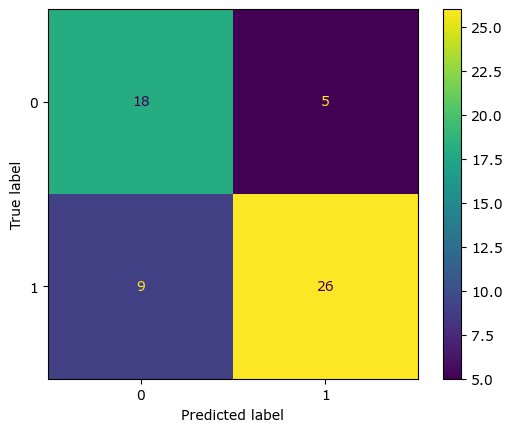

In [5]:
predicted = mamsipls.evaluate_class_model([hpos_test, lpos_test, lneg_test], y_test.array)

We can see that the MB-PLS model with 1 LV has many False Positive and False Negative classifications. It is crucial for PLS-based models to estimate the optimal number of LVs to avoid overfitting. The MamsiPls class provides method ```mamsipls.estimate_lv()``` to estimate number of LVs in the model using k-fold cross-validation (CV). The k-fold CV is repeated k-times corresponding to number of LVs in the most complex model. The lowest possible number of LVs where the model stabilised (model performance did not rise with adding more LVs) was selected as the final model.

For classification task, you can choose from from `'auc', 'precision', 'recall', 'f1', 'accuracy'` metrics to perform LV estimate on mean value of validation CV splits.

auc reaches bent (increase of less than 5.0 % of previous value or decrease) at component 3
auc reaches plateau at component 6
Model re-fitted with n_components = 6


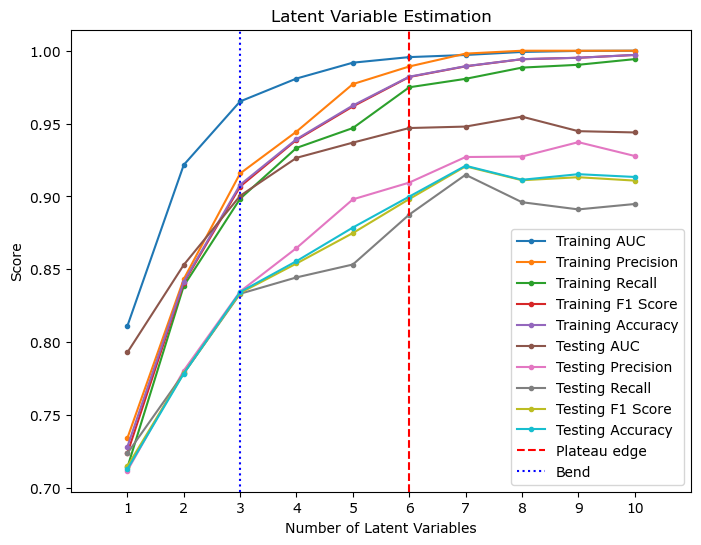

In [6]:
mamsipls.estimate_lv([hpos_train, lpos_train, lneg_train], y_train, metric='auc')

The plot above indicates that the k-fold CV helped to estimate 6 LVs in the model and re-fitted the model to have 6 LVs. You can review the number of LVs in the model or change it as shown in the cell below:

In [7]:
# You can print the number of LVs in the model defined by the estimation 
# function. 
print(mamsipls.n_components)

# Alternatively, you can chose different number of LVs and re-fit the model: 
# mamsipls.n_compontents = 5
# mamsipls.fit([hpos_train, lpos_train, lneg_train], y_train)

6


Now, we can repeat the model evaluation: 

Scores for model with n_components = 6

Accuracy 0.966
Precision 1.0
Recall 0.943
Specificity 1.0
F1 Score 0.971
AUC 0.993


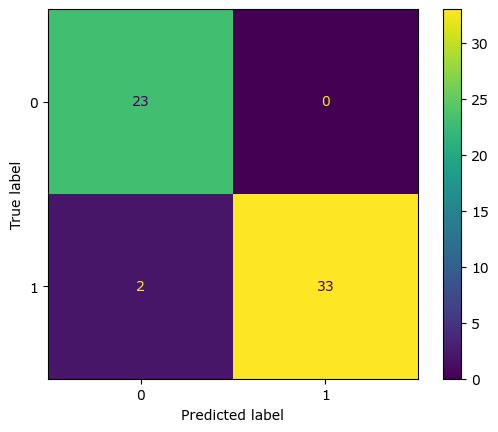

In [8]:
predicted = mamsipls.evaluate_class_model([hpos_test, lpos_test, lneg_test], y_test.array)

The scores and confusion matrix above indicate that the model performance has improved. If we are happy with such model, we can start with model interpretation. 

## Model Interpretation

We can start with reviewing the multi-block Variable Importance in Projection (MB-VIP) scores.
The MB-VIP metric is a sum (weighted by the ammount of variance of Y explained by each respective component) of the squared weight values. It provides a summary of the importance of a variable accounting for all weight vectors. VIPs are bounded between 0 (no effect) and infinity. Because it is calculated from the weights $w$, for PLS models with a single component these are directly proportional to the $w^{2}$. The VIP metric has the disadvantage of pooling together $w$ vectors from components which contribute a very small magnitude to the model's $R^{2}Y$.


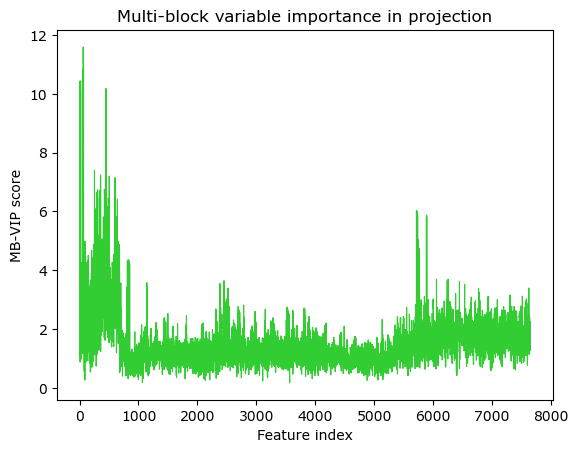

In [9]:
mb_vip = mamsipls.mb_vip(plot=True)

### Permutation testing

Unfortunately, assessment of variable importance in MB-PLS multivariate models is not straight forward, given the multiple choice of parameters and their different interpretation, especially in models with more than 1 PLS component. To obtain a ranking of variables from the data matrix X associated with Y, we recommend using permutation testing coupled with MB-VIP metric to estimate empirical p-values for each variable.

You can perform permutation testing using the `mamsipls.mb_vip_permtest()` method. We recommend to perform at least 10,000 permutations, but ideally >100,000 for good p-value estimate. 

In [10]:
# # Run permutation test to assess the significance of the VIP scores.
# p_vals, null_vip = mamsipls.mb_vip_permtest([hpos, lpos, lneg], y, n_permutations=10000, return_scores=True)

# p_vals = pd.Series(p_vals)
# null_vip = pd.Series(null_vip)

**Note:** Performing the permutation testing with a large number of permutations is a computationally demanding task taking significant amount of time. Our test on a laptop (MacBook Pro, 8 core M1 Pro, 32GB Unified RAM) for 10,000 permutations took ~80 mins. We recommend to run the permutation test on a desktop workstation or a computer cluster. An example code optimised for the Imperial HPC, see `../sample_code/permetes_hpc/` folder.

For your convenience, we pre-calculated permutations for the use in this tutorial. Due to GitHub's file restrictions, the `null_vip` file contains MB-VIP scores for first 400 null models (permutations).

In [11]:
# Load pre-computed p-values and null MB-VIP scores

p_vals = pd.read_csv("../sample_data/p-values_classification.csv", header=None).values

null_vip = pd.read_csv("../sample_data/null_vip_classification.csv", header=None).values

In [12]:
# merge the LC-MS data into a single data frame
x = pd.concat([hpos, lpos, lneg], axis=1)

We can review the empirical null distribution of the MB-VIP scores of a statistically non-significant feature (1) and compare it to a statically significant feature (5769).

In both cases, the dashed line indicates the MB-VIP score for each feature of the observed (non-permuted) model. 

The empirical p-values for *i<sup>th</sup>* feature are calculated be **dividing** the number of MB-VIP scores  of Null model for *i<sup>th</sup>* feature **lower** than the *observed* MB-VIP score for *i<sup>th</sup>* feature, **over the total number of permutations**.

*Note that the pre-calculated `null_vip` file contains MB-VIP scores for first 400 null models (permutations) so the p-value displayed on the plot below does not correspond with the plot itself.*

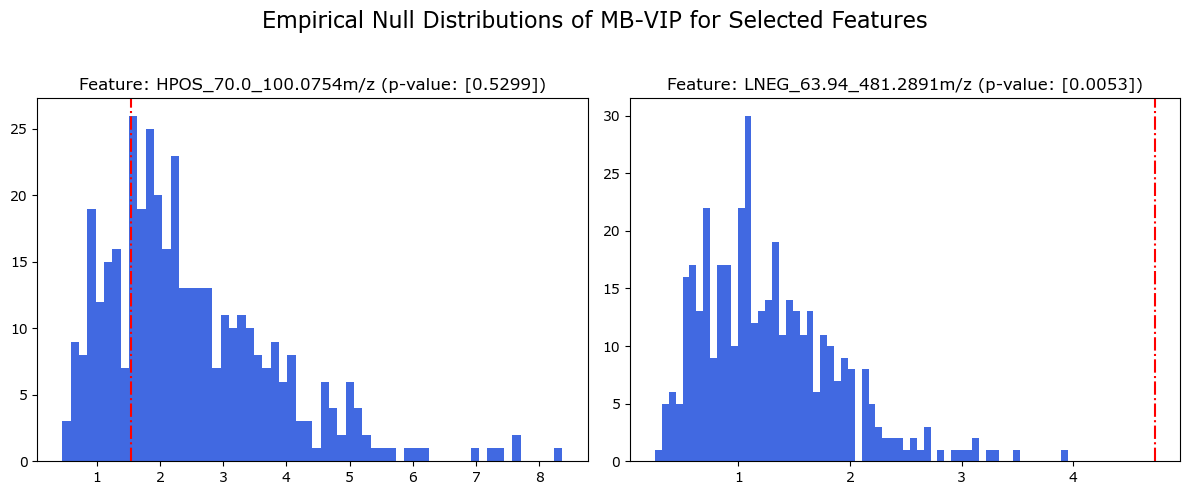

In [13]:
# Feature indices for plot 1 and 2
feature_1 = 1  # statistically non-significant feature
feature_2 = 5769  # statistically significant feature

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

# Main title for the figure
fig.suptitle("Empirical Null Distributions of MB-VIP for Selected Features", fontsize=16)

# First subplot
axs[0].hist(null_vip[feature_1], color='royalblue', bins=60)
axs[0].set_title("Feature: {0}".format(x.columns[feature_1])+" (p-value: {0})".format(p_vals[feature_1]))
axs[0].axvline(mb_vip[feature_1], color='red', linestyle='-.')

# Second subplot
axs[1].hist(null_vip[feature_2], color='royalblue', bins=60)
axs[1].set_title("Feature: {0}".format(x.columns[feature_2])+" (p-value: {0})".format(p_vals[feature_2]))
axs[1].axvline(mb_vip[feature_2], color='red', linestyle='-.')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Select features with p-value < 0.01.
We can also apply multiple testing correction methods to adjust the p-values threshold.

In [14]:

# Select features with p-value < 0.01.
# You can also apply multiple testing correction methods to adjust the p-values threshold.
mask = np.where(p_vals < 0.01)
selected = x.iloc[:, mask[0]]

In [15]:
# We can review which features were selected.
selected

,HPOS_189.93_341.1854m/z,HPOS_294.31_479.3326m/z,HPOS_294.81_499.348m/z,HPOS_276.89_673.5281m/z,HPOS_276.76_674.5313m/z,HPOS_243.75_728.5213m/z,HPOS_243.58_729.5249m/z,HPOS_292.76_1051.6701m/z,HPOS_291.25_1055.6939m/z,LPOS_169.17_402.3468m/z,...,LNEG_295.69_857.5187m/z,LNEG_295.28_859.5248m/z,LNEG_341.93_871.5704m/z,LNEG_345.5_897.514m/z,LNEG_361.55_902.6018m/z,LNEG_295.35_977.4768m/z,LNEG_488.94_1049.7618m/z,LNEG_435.42_1125.5003m/z,LNEG_468.49_1150.5673m/z,LNEG_365.39_1599.1436m/z
0,0.000000,134770.966600,312393.483651,154973.083621,66304.940562,580203.422446,86948.218356,19730.048902,34464.137488,7409.882038,...,1.650949e+06,249123.833071,563.154564,74765.625800,217085.484903,20084.135169,55837.288034,36588.817415,61031.804510,24121.061604
1,24.973921,111024.360595,287109.944784,91512.177768,37804.123153,444074.232198,64004.518982,18245.962113,12011.366767,43550.988882,...,2.338290e+06,352861.904776,394.981980,74778.319427,162624.131473,29442.976271,41376.027856,51394.864445,63851.575553,41384.988199
2,17.361123,137779.610695,383271.717463,130372.553333,54023.932502,199887.055981,31586.457472,23530.772184,20019.485002,63983.052769,...,1.866029e+06,286098.559581,1210.111946,77877.207122,202666.439318,23813.652352,198.751732,53189.804549,55844.946959,33600.233571
3,50.522419,130188.835096,289439.273884,131933.160973,55605.096180,227172.880882,34880.032712,30719.164396,22254.713309,46332.329581,...,2.601886e+06,405123.377898,20855.862831,86954.802154,119927.101219,30354.948635,206.908407,34362.381792,62829.784251,50793.899984
4,0.000000,120719.908963,254046.794677,120328.249484,49857.209731,343712.329268,54863.712364,28703.059285,19616.305262,10668.370910,...,2.475767e+06,361093.806420,1007.548601,88547.230978,312300.010345,26817.913297,38914.441328,45680.530841,38169.911233,29819.959337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,0.000000,144844.294875,382813.182477,186899.109236,120615.257539,195139.608098,76816.019343,9949.034748,27050.779706,5042.000251,...,4.882601e+06,626669.857178,16927.720795,60969.726437,269667.764994,56633.957493,113946.184720,45185.267597,47393.298152,59923.782899
573,69311.595029,97668.813671,239278.813514,108310.684294,69549.607965,309408.315962,121416.513967,24271.806266,19535.765486,38880.546193,...,4.091367e+06,543294.999044,16304.388924,73995.807754,286654.314238,46689.302602,108673.075285,44964.564442,63615.155395,64419.161210
574,16.984147,83384.637914,210225.329186,106400.635515,24760.273789,191453.112341,75165.328224,3090.537659,22256.908338,11992.400723,...,2.331475e+06,325164.273247,17116.464250,86253.327879,253681.725849,25827.205398,107794.136098,50497.038572,65707.996642,45226.149323
575,0.000000,95225.116864,225461.952927,70048.853763,44497.922159,110727.891733,37815.257104,19454.790057,9328.100778,25149.727376,...,4.162196e+06,550363.817793,10110.600403,82609.757123,175057.934302,45296.620913,64241.025044,39508.054573,61198.969498,57371.361449


## Interpretation of Selected Features

You can use MAMSI Structural Search tool (`MamsiStructSearch()`) to help you understand the nature of statistically significant features. 

Firstly, all features are split into retention time (*RT*) windows of 5 seconds intervals, then each RT window is searched for isotopologue signature’s by searching mass differences of 1.00335 *Da* between mass-to-charge ratios (*m/z*) of the features; if two or more features resemble mass isotopologue signature then they are grouped together. This is followed by a search for common adduct signatures. This is achieved by calculating hypothetical neutral masses based on common adducts in electrospray ionisation. If hypothetical neutral masses match for two or more features within a pre-defined tolerance (15 *ppm*) then these features are grouped together. Overlapping adduct clusters and isotopologues clusters are then merged to form structural clusters. Further, we search cross-assay clusters using [M+H]<sup>+</sup>/[M-H]<sup>-</sup> as link references. Additionally, our structural search tool, that utilises region of interest [(ROI) files](https://github.com/phenomecentre/npc-open-lcms) from [peakPantheR](https://academic.oup.com/bioinformatics/article/37/24/4886/6298587), allows for automated annotation of  some features based on the *RT* for a given chromatography and m/z.

In [16]:
# First, we need to define the MamsiStructSearch object 
# and choose the tolerances for the retention time and m/z matching.
struct = MamsiStructSearch(rt_win=5, ppm=10)

# Load Selected LC-MS Features
struct.load_lcms(selected)

We can then perform the structural search. 
Note, use the `annotate=True` to get the annotation for selected features 
only if your LC-MS data originate from the National Phenome Centre or follow the NPC protocol.

In [17]:
struct.get_structural_clusters(annotate=True)
pd.set_option("display.max_rows", 15)

We also need to perform hierarchical correlation clustering between selected features. 
You can choose either silhouette method or define a straight cut-off on the dendrogram

Best number of clusters based on silhouette score: 8
Silhouette score for 8 clusters: 0.2436798413177305


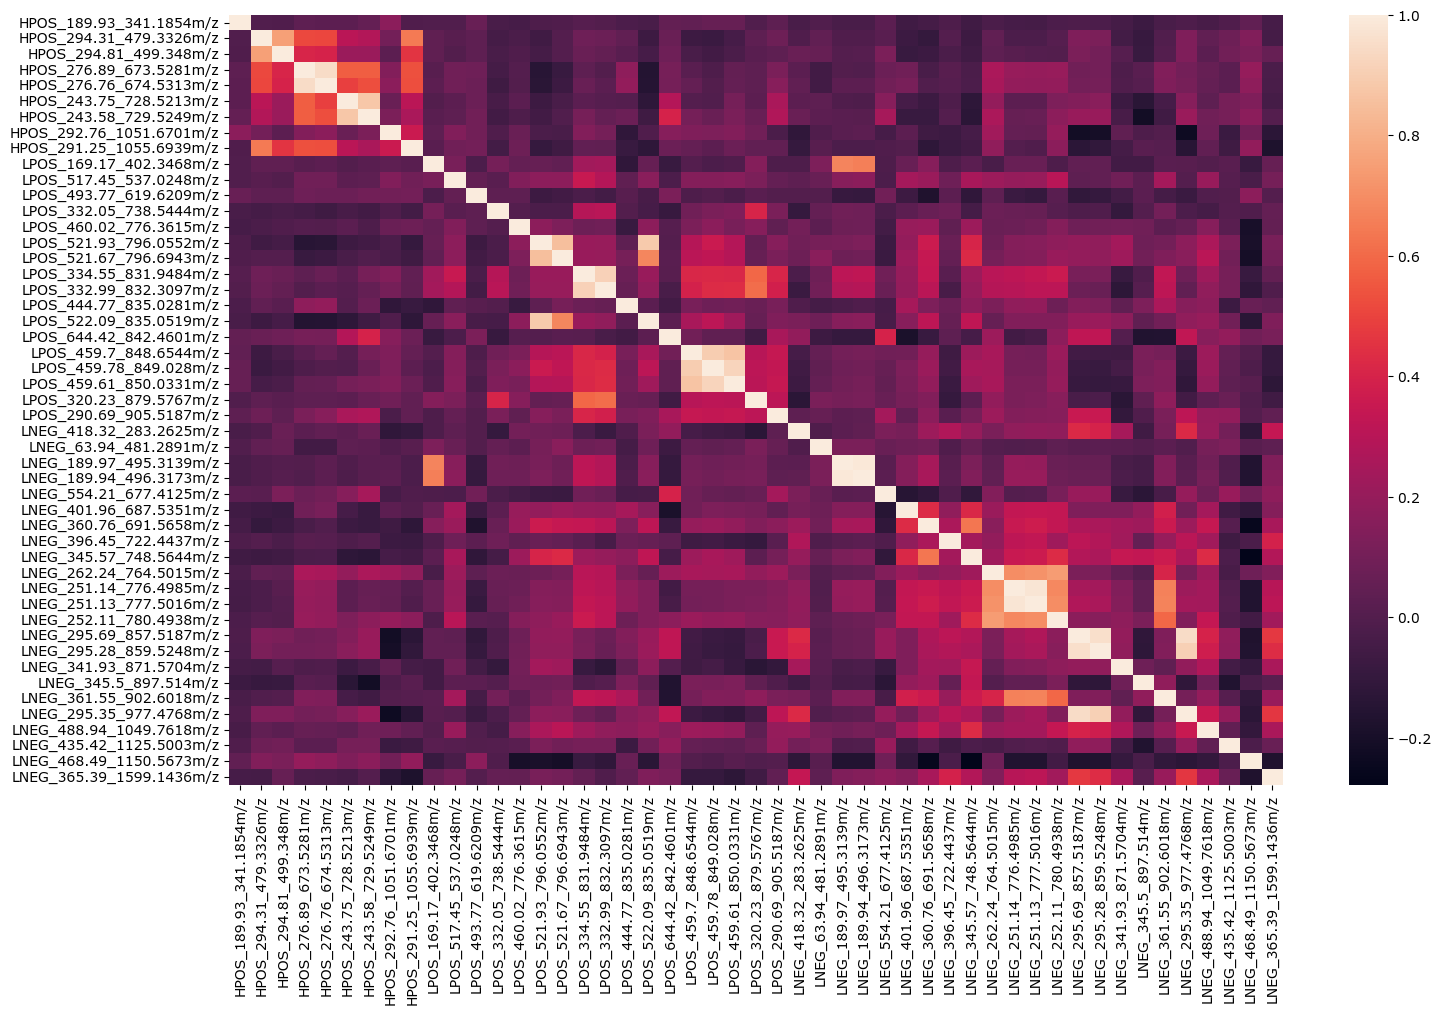

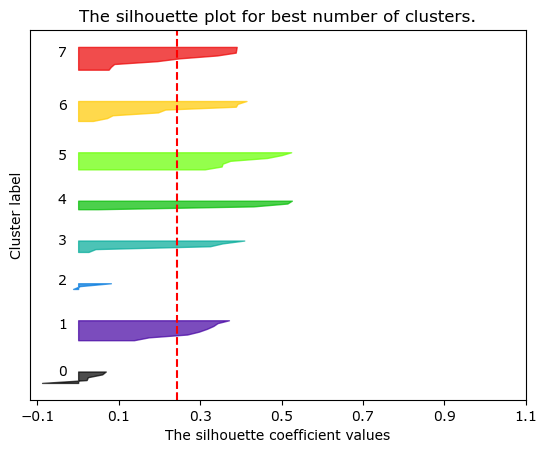

In [18]:
struct.get_correlation_clusters(flat_method='silhouette', max_clusters=11)

We can now review the output table and 

In [19]:
struct.structural_links

,Feature,Assay,RT,m/z,Isotopologue group,Isotopologue pattern,Adduct group,Expected neutral mass,Observed neutral mass,Neutral mass |difference ppm|,...,Structural cluster,cpdName,chemicalFormula,ion,mzMin,mzMax,rtMin,rtMax,Cross-assay link,Correlation cluster
0,HPOS_189.93_341.1854m/z,HPOS,189.93,341.1854,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,HPOS_294.31_479.3326m/z,HPOS,294.31,479.3326,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,HPOS_294.81_499.348m/z,HPOS,294.81,499.348,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,HPOS_276.89_673.5281m/z,HPOS,276.89,673.5281,1.0,0.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,HPOS_276.76_674.5313m/z,HPOS,276.76,674.5313,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,LNEG_295.35_977.4768m/z,LNEG,295.35,977.4768,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
45,LNEG_488.94_1049.7618m/z,LNEG,488.94,1049.7618,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
46,LNEG_435.42_1125.5003m/z,LNEG,435.42,1125.5003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47,LNEG_468.49_1150.5673m/z,LNEG,468.49,1150.5673,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


Finally we can visualise the structural relationships in a network plot. 
The different node colours represent different flattened hierarchical correlation clusters, while the edges between nodes identify their structural links. You can also save the network as an NX object and review in [Cytoscape](https://cytoscape.org) to get better insight on what these the structural relationship between individual features are (e.g. adduct links, isotopologues, cross-assay links).

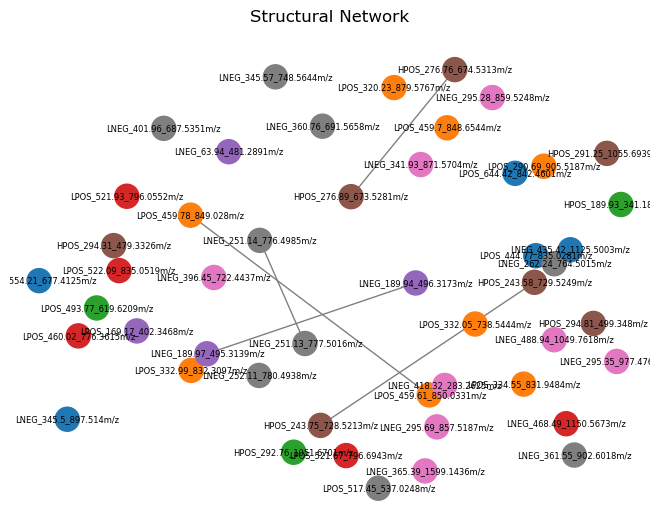

In [20]:
network = struct.get_structural_network(include_all=True, interactive=False, labels=True, return_nx_object=True)

Alternatively, we can also visualise the network plot using the interactive 'pvis' library. 

In [21]:
# struct.get_structural_network(include_all=True, interactive=True)